In [1]:
!pip install git+https://github.com/leehosu01/optopt.git@0.1.0-td3
!pip install --no-cache-dir  --force-reinstall --no-deps  git+https://github.com/leehosu01/optopt.git@0.1.0-td3
!nvidia-smi

  Cloning https://github.com/leehosu01/optopt.git (to revision 0.1.0-td3) to /tmp/pip-req-build-vvbll2mo
  Running command git clone -q https://github.com/leehosu01/optopt.git /tmp/pip-req-build-vvbll2mo
  Running command git checkout -b 0.1.0-td3 --track origin/0.1.0-td3
  Switched to a new branch '0.1.0-td3'
  Branch '0.1.0-td3' set up to track remote branch '0.1.0-td3' from 'origin'.
  Cloning https://github.com/leehosu01/optopt.git (to revision 0.1.0-td3) to /tmp/pip-req-build-f12hr71y
  Running command git clone -q https://github.com/leehosu01/optopt.git /tmp/pip-req-build-f12hr71y
  Running command git checkout -b 0.1.0-td3 --track origin/0.1.0-td3
  Switched to a new branch '0.1.0-td3'
  Branch '0.1.0-td3' set up to track remote branch '0.1.0-td3' from 'origin'.
  Created wheel for optimizer-optimizer: filename=optimizer_optimizer-0.1.0_td3-py3-none-any.whl size=24302 sha256=341f057f4fbb4942e764b3a09adc6af490b6bdc789c92ad0b21d9dc96c486681
  Stored in directory: /tmp/pip-ephem-wh

In [2]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
def auto_select_accelerator():
    TPU_DETECTED = False
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
        TPU_DETECTED =True
        #policy = mixed_precision.Policy('mixed_bfloat16')
        #mixed_precision.set_global_policy(policy)
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return strategy, TPU_DETECTED
strategy, TPU_DETECTED = auto_select_accelerator()

from tensorflow.keras import datasets, layers, models
#(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
(train_images, train_labels), (test_images, test_labels) = datasets.cifar100.load_data()
train_images = train_images.reshape((50000, 32, 32, 3))
test_images = test_images.reshape((10000, 32, 32, 3))

train_images, test_images = train_images / 255.0, test_images / 255.0
def build_dataset(*args):
    return tf.data.Dataset.from_tensor_slices(args).cache().shuffle(1024 *8).batch(256, True)
TR_DT = build_dataset(train_images, train_labels)
VL_DT = build_dataset(test_images, test_labels)
num_classes = 100

Running on 1 replicas


In [3]:
from optopt import manager
import optopt
from adabelief_tf import AdaBeliefOptimizer
def build_model():
    model = tf.keras.models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), use_bias = False, input_shape=train_images.shape[-3:]))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Activation('elu'))
    model.add(layers.Conv2D(128, (3, 3), use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Activation('elu'))
    model.add(layers.Conv2D(128, (3, 3), use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Activation('elu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model
def model_compile(label_smoothing, **opt_params):
    def scc_ls(label_smoothing):
        def _sub(y_true, y_pred):
            y_true = tf.squeeze(tf.one_hot(tf.cast(y_true, tf.int32), num_classes))
            y_true = y_true * (1.0 - label_smoothing) + (label_smoothing / num_classes)
            return tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        return _sub
    class SCC_LS(tf.keras.metrics.Metric):
        def __init__(self, label_smoothing, name, **kwargs):
            super(SCC_LS, self).__init__(name=name, **kwargs)
            self.mean = tf.keras.metrics.Mean()
            self.label_smoothing = label_smoothing
        def update_state(self, y_true, y_pred, sample_weight=None):
            y_true = tf.squeeze(tf.one_hot(tf.cast(y_true, tf.int32), num_classes))
            y_true = y_true * (1.0 - self.label_smoothing) + (self.label_smoothing / num_classes)
            loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
            self.mean.update_state(tf.reduce_mean(loss))
        def reset_state(self):self.mean.reset_state()
        def result(self):return self.mean.result()
    with strategy.scope():
        model = build_model()
        model.compile(optimizer=AdaBeliefOptimizer(**opt_params),
                      loss=scc_ls(label_smoothing),
                      metrics= [tf.keras.metrics.SparseTopKCategoricalAccuracy(k= 1 , name = f"acc")] + \
                              [tf.keras.metrics.SparseTopKCategoricalAccuracy(k= i , name = f"sca_{i}") for i in range(2, 5)] + \
                              [SCC_LS((i+0.5) / 10, name = f"scc_{i}") for i in range(10)]
                      )
    return model
max_epochs = 20
base_feature = [f"sca_{i}" for i in range(2, 5)] + [f"scc_{i}" for i in range(10)]
config = optopt.Config(sequence_length = max_epochs,
                log_interval = 1,
                collect_episodes_for_env_testing = 0,
                policy_save_interval = 4,)
optim = manager.Manager(using_features = [J+I for I in base_feature for J in ['', 'val_']],
                        objective = 'val_acc',
                        direction = 'maximize',
                        config = config)

opt_parameter = {
                    'label_smoothing':optim.Variables.loguniform('label_smoothing', 0.01, 0.5),
                    'learning_rate':optim.Variables.loguniform('learning_rate', 1e-5, 1e-3),
                    'beta_1':optim.Variables.uniform('beta_1', 0.8, 0.95),
                    'beta_2':optim.Variables.uniform('beta_2', 0.9, 0.999),
                    'epsilon':optim.Variables.loguniform('epsilon', 1e-14, 1e-6),
                    'weight_decay':optim.Variables.loguniform('weight_decay', 1e-8, 1e-2),
                    'rectify':True,
                    'amsgrad':False,
                    'sma_threshold':5.0,
                    'print_change_log':False}
model = model_compile(**opt_parameter)

opt_parameter['learning_rate'].assign(0.)
model.fit(TR_DT, epochs=1, steps_per_epoch=1)
opt_W = model.optimizer.get_weights()
optim.compile()

1/1 [==============================] - 5s 5s/step - loss: 5.7717 - acc: 0.0039 - sca_2: 0.0195 - sca_3: 0.0352 - sca_4: 0.0430 - scc_0: 5.7750 - scc_1: 5.7591 - scc_2: 5.7433 - scc_3: 5.7274 - scc_4: 5.7115 - scc_5: 5.6957 - scc_6: 5.6798 - scc_7: 5.6640 - scc_8: 5.6481 - scc_9: 5.6323


['beta_1', 'beta_2', 'epsilon', 'label_smoothing', 'learning_rate', 'weight_decay']
GEN 0
ENV._reset :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] 0 False 0


Instructions for updating:
rename to distribute_datasets_from_function


Instructions for updating:
rename to distribute_datasets_from_function


start training


ENV._step => call set_action [0.4222342  0.53892154 0.5545807  0.5361489  0.45885792 0.43093625]
ENV._step <= return set_action
Epoch 1/20
195/195 [==============================] - 5s 25ms/step - loss: 4.3798 - acc: 0.0818 - sca_2: 0.1323 - sca_3: 0.1713 - sca_4: 0.2037 - scc_0: 4.3520 - scc_1: 4.4403 - scc_2: 4.5286 - scc_3: 4.6169 - scc_4: 4.7051 - scc_5: 4.7934 - scc_6: 4.8817 - scc_7: 4.9700 - scc_8: 5.0583 - scc_9: 5.1466 - val_loss: 4.6624 - val_acc: 0.0243 - val_sca_2: 0.0423 - val_sca_3: 0.0556 - val_sca_4: 0.0738 - val_scc_0: 4.6523 - val_scc_1: 4.6843 - val_scc_2: 4.7163 - val_scc_3: 4.7483 - val_scc_4: 4.7804 - val_scc_5: 4.8124 - val_scc_6: 4.8444 - val_scc_7: 4.8764 - val_scc_8: 4.9084 - val_scc_9: 4.9404
ENV._step => call set_action [0.46224704 0.39133427 0.50397116 0.34314942 0.5859957  0.46925488]
ENV._step <= return set_action
Epoch 2/20
195/195 [==============================] - 4s 19ms/step - loss: 3.6285 - acc: 0.1812 - sca_2: 0.2721 - sca_3: 0.3341 - sca_4: 0.3856

ENV._step => call set_action [0.48972228 0.46128815 0.47351265 0.47520894 0.44265217 0.4357656 ]
ENV._step <= return set_action
Epoch 1/20
195/195 [==============================] - 4s 19ms/step - loss: 4.3219 - acc: 0.0804 - sca_2: 0.1307 - sca_3: 0.1698 - sca_4: 0.2037 - scc_0: 4.3085 - scc_1: 4.4030 - scc_2: 4.4976 - scc_3: 4.5922 - scc_4: 4.6868 - scc_5: 4.7814 - scc_6: 4.8760 - scc_7: 4.9706 - scc_8: 5.0652 - scc_9: 5.1598 - val_loss: 4.6106 - val_acc: 0.0217 - val_sca_2: 0.0398 - val_sca_3: 0.0583 - val_sca_4: 0.0762 - val_scc_0: 4.6060 - val_scc_1: 4.6383 - val_scc_2: 4.6705 - val_scc_3: 4.7028 - val_scc_4: 4.7350 - val_scc_5: 4.7672 - val_scc_6: 4.7995 - val_scc_7: 4.8317 - val_scc_8: 4.8640 - val_scc_9: 4.8962
ENV._step => call set_action [0.5837369  0.5097574  0.49338964 0.5514353  0.47711307 0.6660259 ]
ENV._step <= return set_action
Epoch 2/20
195/195 [==============================] - 4s 18ms/step - loss: 3.7859 - acc: 0.1684 - sca_2: 0.2534 - sca_3: 0.3145 - sca_4: 0.3626

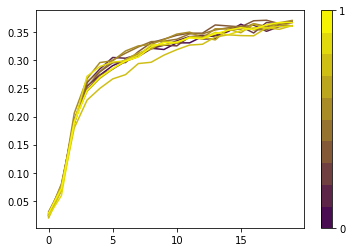

GEN 10
ENV._reset :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] 0 False 0
ENV._step => call set_action [0.43549132 0.5791277  0.5748571  0.62811416 0.53989625 0.5316106 ]
ENV._step <= return set_action
Epoch 1/20
195/195 [==============================] - 4s 18ms/step - loss: 4.2814 - acc: 0.0962 - sca_2: 0.1529 - sca_3: 0.1961 - sca_4: 0.2317 - scc_0: 4.2119 - scc_1: 4.3161 - scc_2: 4.4202 - scc_3: 4.5243 - scc_4: 4.6285 - scc_5: 4.7326 - scc_6: 4.8367 - scc_7: 4.9408 - scc_8: 5.0450 - scc_9: 5.1491 - val_loss: 4.7340 - val_acc: 0.0286 - val_sca_2: 0.0417 - val_sca_3: 0.0547 - val_sca_4: 0.0663 - val_scc_0: 4.7129 - val_scc_1: 4.7445 - val_scc_2: 4.7762 - val_scc_3: 4.8078 - val_scc_4: 4.8395 - val_scc_5: 4.8712 - val_scc_6: 4.9028 - val_scc_7: 4.9345 - val_scc_8: 4.9661 - val_scc_9: 4.9978
ENV._step => call set_action [0.48599896 0.50077146 0.4513203  0.558294   0.54870147 0.5307331 ]
ENV._step <= return set_action
Epoch 2/20
195/195 [========

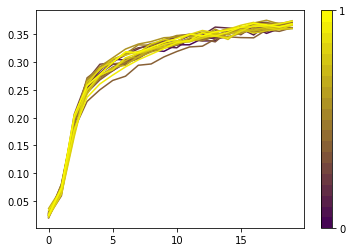

GEN 20
ENV._reset :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] 0 False 0
ENV._step => call set_action [0.44458467 0.4226044  0.58592284 0.5020265  0.5454386  0.5107807 ]
ENV._step <= return set_action
Epoch 1/20
195/195 [==============================] - 4s 18ms/step - loss: 4.1952 - acc: 0.1054 - sca_2: 0.1642 - sca_3: 0.2078 - sca_4: 0.2454 - scc_0: 4.1709 - scc_1: 4.2851 - scc_2: 4.3994 - scc_3: 4.5136 - scc_4: 4.6278 - scc_5: 4.7420 - scc_6: 4.8562 - scc_7: 4.9705 - scc_8: 5.0847 - scc_9: 5.1989 - val_loss: 4.7870 - val_acc: 0.0287 - val_sca_2: 0.0406 - val_sca_3: 0.0524 - val_sca_4: 0.0679 - val_scc_0: 4.7798 - val_scc_1: 4.8134 - val_scc_2: 4.8470 - val_scc_3: 4.8805 - val_scc_4: 4.9141 - val_scc_5: 4.9477 - val_scc_6: 4.9813 - val_scc_7: 5.0148 - val_scc_8: 5.0484 - val_scc_9: 5.0820
ENV._step => call set_action [0.5616368  0.52501273 0.5091921  0.54164106 0.5682302  0.5781692 ]
ENV._step <= return set_action
Epoch 2/20
195/195 [========

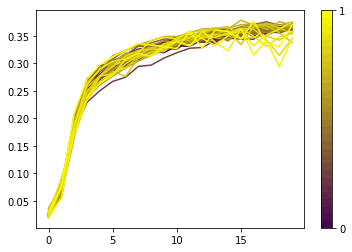

GEN 30
ENV._reset :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] 0 False 0
ENV._step => call set_action [0.5475451  0.5983984  0.43303853 0.48008633 0.5858324  0.5001565 ]
ENV._step <= return set_action
Epoch 1/20
195/195 [==============================] - 4s 18ms/step - loss: 4.2008 - acc: 0.1014 - sca_2: 0.1607 - sca_3: 0.2070 - sca_4: 0.2440 - scc_0: 4.1832 - scc_1: 4.2974 - scc_2: 4.4116 - scc_3: 4.5259 - scc_4: 4.6401 - scc_5: 4.7543 - scc_6: 4.8685 - scc_7: 4.9827 - scc_8: 5.0969 - scc_9: 5.2111 - val_loss: 4.6741 - val_acc: 0.0433 - val_sca_2: 0.0652 - val_sca_3: 0.0837 - val_sca_4: 0.0975 - val_scc_0: 4.6680 - val_scc_1: 4.7076 - val_scc_2: 4.7472 - val_scc_3: 4.7867 - val_scc_4: 4.8263 - val_scc_5: 4.8659 - val_scc_6: 4.9054 - val_scc_7: 4.9450 - val_scc_8: 4.9846 - val_scc_9: 5.0241
ENV._step => call set_action [0.507343   0.47407532 0.50728005 0.5153123  0.52967364 0.5061422 ]
ENV._step <= return set_action
Epoch 2/20
195/195 [========

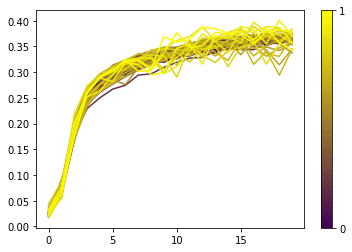

GEN 40
ENV._reset :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] 0 False 0
ENV._step => call set_action [0.5215936  0.43338478 0.5102643  0.52078956 0.5809494  0.52034986]
ENV._step <= return set_action
Epoch 1/20
195/195 [==============================] - 4s 18ms/step - loss: 4.2045 - acc: 0.1049 - sca_2: 0.1638 - sca_3: 0.2067 - sca_4: 0.2429 - scc_0: 4.1745 - scc_1: 4.2867 - scc_2: 4.3989 - scc_3: 4.5112 - scc_4: 4.6234 - scc_5: 4.7356 - scc_6: 4.8478 - scc_7: 4.9601 - scc_8: 5.0723 - scc_9: 5.1845 - val_loss: 4.6948 - val_acc: 0.0283 - val_sca_2: 0.0421 - val_sca_3: 0.0629 - val_sca_4: 0.0787 - val_scc_0: 4.6855 - val_scc_1: 4.7203 - val_scc_2: 4.7550 - val_scc_3: 4.7897 - val_scc_4: 4.8245 - val_scc_5: 4.8592 - val_scc_6: 4.8939 - val_scc_7: 4.9287 - val_scc_8: 4.9634 - val_scc_9: 4.9981
ENV._step => call set_action [0.4566167  0.46343765 0.5048013  0.48907712 0.62106055 0.41035232]
ENV._step <= return set_action
Epoch 2/20
195/195 [========

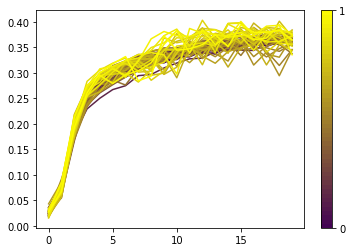

GEN 50
ENV._reset :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] 0 False 0
ENV._step => call set_action [0.5359347  0.5611141  0.5766873  0.46662003 0.50317234 0.52988946]
ENV._step <= return set_action
Epoch 1/20
195/195 [==============================] - 4s 18ms/step - loss: 4.2685 - acc: 0.0936 - sca_2: 0.1484 - sca_3: 0.1896 - sca_4: 0.2240 - scc_0: 4.2561 - scc_1: 4.3593 - scc_2: 4.4624 - scc_3: 4.5655 - scc_4: 4.6687 - scc_5: 4.7718 - scc_6: 4.8750 - scc_7: 4.9781 - scc_8: 5.0813 - scc_9: 5.1844 - val_loss: 4.7193 - val_acc: 0.0309 - val_sca_2: 0.0449 - val_sca_3: 0.0565 - val_sca_4: 0.0677 - val_scc_0: 4.7154 - val_scc_1: 4.7475 - val_scc_2: 4.7795 - val_scc_3: 4.8116 - val_scc_4: 4.8436 - val_scc_5: 4.8757 - val_scc_6: 4.9078 - val_scc_7: 4.9398 - val_scc_8: 4.9719 - val_scc_9: 5.0039
ENV._step => call set_action [0.47897068 0.48849005 0.47814757 0.53881377 0.53349197 0.32610434]
ENV._step <= return set_action
Epoch 2/20
195/195 [========

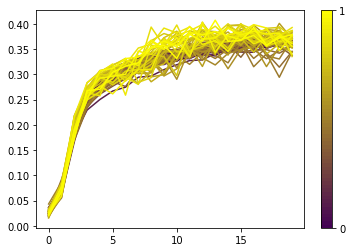

GEN 60
ENV._reset :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] 0 False 0
ENV._step => call set_action [0.4084363  0.5278084  0.43031034 0.52163833 0.50044525 0.5297041 ]
ENV._step <= return set_action
Epoch 1/20
195/195 [==============================] - 4s 18ms/step - loss: 4.2730 - acc: 0.0938 - sca_2: 0.1487 - sca_3: 0.1891 - sca_4: 0.2242 - scc_0: 4.2449 - scc_1: 4.3491 - scc_2: 4.4532 - scc_3: 4.5574 - scc_4: 4.6616 - scc_5: 4.7657 - scc_6: 4.8699 - scc_7: 4.9740 - scc_8: 5.0782 - scc_9: 5.1824 - val_loss: 4.6672 - val_acc: 0.0294 - val_sca_2: 0.0445 - val_sca_3: 0.0579 - val_sca_4: 0.0725 - val_scc_0: 4.6579 - val_scc_1: 4.6923 - val_scc_2: 4.7266 - val_scc_3: 4.7609 - val_scc_4: 4.7952 - val_scc_5: 4.8295 - val_scc_6: 4.8638 - val_scc_7: 4.8981 - val_scc_8: 4.9324 - val_scc_9: 4.9667
ENV._step => call set_action [0.44087622 0.53977835 0.51778847 0.47006512 0.5345968  0.49332148]
ENV._step <= return set_action
Epoch 2/20
195/195 [========

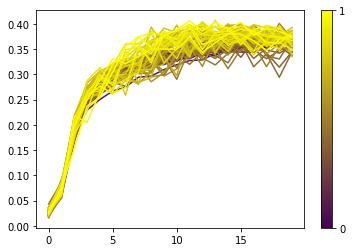

GEN 70
ENV._reset :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] 0 False 0
ENV._step => call set_action [0.4456107  0.4840542  0.4784305  0.4596321  0.43800616 0.44773197]
ENV._step <= return set_action
Epoch 1/20
195/195 [==============================] - 3s 18ms/step - loss: 4.3464 - acc: 0.0830 - sca_2: 0.1332 - sca_3: 0.1713 - sca_4: 0.2030 - scc_0: 4.3369 - scc_1: 4.4284 - scc_2: 4.5199 - scc_3: 4.6114 - scc_4: 4.7028 - scc_5: 4.7943 - scc_6: 4.8858 - scc_7: 4.9772 - scc_8: 5.0687 - scc_9: 5.1602 - val_loss: 4.6090 - val_acc: 0.0258 - val_sca_2: 0.0466 - val_sca_3: 0.0648 - val_sca_4: 0.0796 - val_scc_0: 4.6054 - val_scc_1: 4.6400 - val_scc_2: 4.6746 - val_scc_3: 4.7092 - val_scc_4: 4.7438 - val_scc_5: 4.7784 - val_scc_6: 4.8130 - val_scc_7: 4.8476 - val_scc_8: 4.8822 - val_scc_9: 4.9168
ENV._step => call set_action [0.5240938  0.45463842 0.62656343 0.33877188 0.52558583 0.3845691 ]
ENV._step <= return set_action
Epoch 2/20
195/195 [========

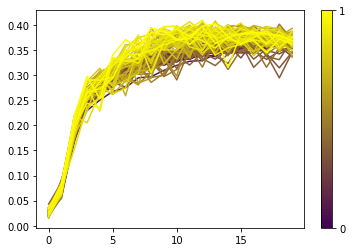

GEN 80
ENV._reset :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] 0 False 0
ENV._step => call set_action [0.53916264 0.47717816 0.43181607 0.48908505 0.48198032 0.3318051 ]
ENV._step <= return set_action
Epoch 1/20
195/195 [==============================] - 4s 18ms/step - loss: 4.2904 - acc: 0.0918 - sca_2: 0.1457 - sca_3: 0.1858 - sca_4: 0.2193 - scc_0: 4.2724 - scc_1: 4.3734 - scc_2: 4.4744 - scc_3: 4.5753 - scc_4: 4.6763 - scc_5: 4.7772 - scc_6: 4.8782 - scc_7: 4.9791 - scc_8: 5.0801 - scc_9: 5.1810 - val_loss: 4.6363 - val_acc: 0.0203 - val_sca_2: 0.0352 - val_sca_3: 0.0612 - val_sca_4: 0.0788 - val_scc_0: 4.6301 - val_scc_1: 4.6652 - val_scc_2: 4.7003 - val_scc_3: 4.7354 - val_scc_4: 4.7705 - val_scc_5: 4.8056 - val_scc_6: 4.8407 - val_scc_7: 4.8758 - val_scc_8: 4.9109 - val_scc_9: 4.9460
ENV._step => call set_action [0.508181   0.41022426 0.44610074 0.43917814 0.5600658  0.4372186 ]
ENV._step <= return set_action
Epoch 2/20
195/195 [========

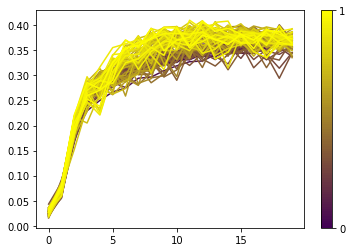

GEN 90
ENV._reset :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] 0 False 0
ENV._step => call set_action [0.50249577 0.48514178 0.48292485 0.4594774  0.57327056 0.3640787 ]
ENV._step <= return set_action
Epoch 1/20
195/195 [==============================] - 4s 18ms/step - loss: 4.1907 - acc: 0.1037 - sca_2: 0.1611 - sca_3: 0.2057 - sca_4: 0.2419 - scc_0: 4.1784 - scc_1: 4.2971 - scc_2: 4.4158 - scc_3: 4.5345 - scc_4: 4.6532 - scc_5: 4.7719 - scc_6: 4.8906 - scc_7: 5.0093 - scc_8: 5.1280 - scc_9: 5.2467 - val_loss: 4.7357 - val_acc: 0.0398 - val_sca_2: 0.0575 - val_sca_3: 0.0767 - val_sca_4: 0.0916 - val_scc_0: 4.7318 - val_scc_1: 4.7701 - val_scc_2: 4.8084 - val_scc_3: 4.8467 - val_scc_4: 4.8850 - val_scc_5: 4.9233 - val_scc_6: 4.9616 - val_scc_7: 4.9999 - val_scc_8: 5.0383 - val_scc_9: 5.0766
ENV._step => call set_action [0.45792094 0.3911119  0.47668684 0.38313097 0.5140053  0.38084307]
ENV._step <= return set_action
Epoch 2/20
195/195 [========

In [4]:
from matplotlib import pyplot as plt
from matplotlib import colors as cmaps
import matplotlib
import numpy as np
def show_enhance(history):
    color_0 = np.asarray([65,0,85, 255])
    color_1 = np.asarray([255, 255,0, 255])
    cmap = []
    for i, hist in enumerate(history):
      progress = (i+0.5) / len(history)
      color = color_1 * progress + color_0 * (1. - progress)
      color = color/255.01
      cmap.append(color)
      plt.plot(hist.history['val_acc'], color = color)

    cmap = cmaps.ListedColormap(cmap)
    sm = matplotlib.cm.ScalarMappable(cmap = cmap)
    plt.colorbar(sm, ticks=np.arange(len(history)))
    plt.show()

print(optim.Variables.get_param_names())
history = []

for gen in range(100):
    if gen and gen % 10 == 0: show_enhance(history)
    print(f"GEN {gen}")
    new_model = build_model()
    model.set_weights(new_model.get_weights())
    model.optimizer.set_weights(opt_W)
    callback = optim.get_callback()
    #asyncio.run(fitting(model, callback))
    history.append(model.fit(TR_DT, validation_data = VL_DT, epochs = max_epochs, callbacks = [callback]))

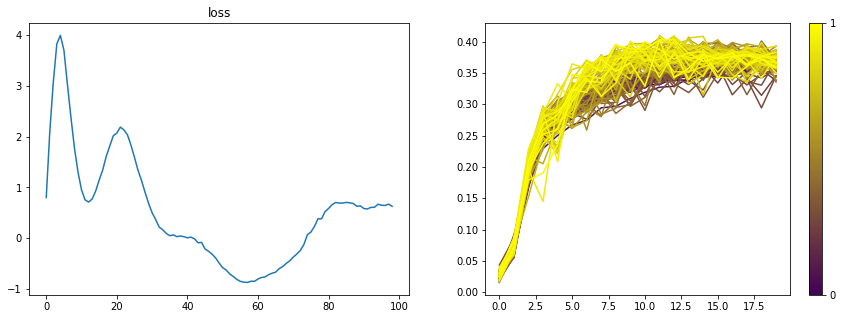

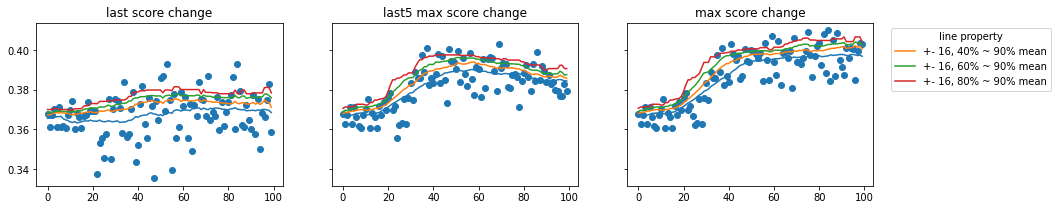

GEN 100
ENV._reset :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] 0 False 0
ENV._step => call set_action [0.4513168  0.4728342  0.48388177 0.51528656 0.583277   0.56551903]
ENV._step <= return set_action
Epoch 1/20
195/195 [==============================] - 5s 23ms/step - loss: 4.1719 - acc: 0.1076 - sca_2: 0.1683 - sca_3: 0.2153 - sca_4: 0.2530 - scc_0: 4.1422 - scc_1: 4.2607 - scc_2: 4.3793 - scc_3: 4.4979 - scc_4: 4.6165 - scc_5: 4.7350 - scc_6: 4.8536 - scc_7: 4.9722 - scc_8: 5.0908 - scc_9: 5.2094 - val_loss: 4.7374 - val_acc: 0.0208 - val_sca_2: 0.0389 - val_sca_3: 0.0558 - val_sca_4: 0.0730 - val_scc_0: 4.7287 - val_scc_1: 4.7634 - val_scc_2: 4.7982 - val_scc_3: 4.8330 - val_scc_4: 4.8678 - val_scc_5: 4.9026 - val_scc_6: 4.9374 - val_scc_7: 4.9721 - val_scc_8: 5.0069 - val_scc_9: 5.0417
ENV._step => call set_action [0.49605525 0.48041594 0.48506138 0.41909027 0.5565406  0.3060713 ]
ENV._step <= return set_action
Epoch 2/20
195/195 [=======

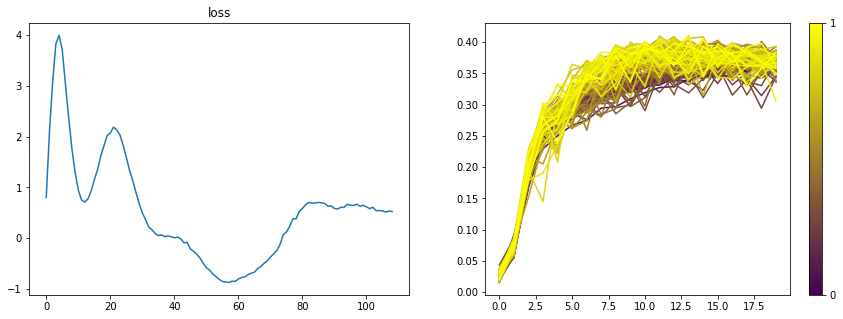

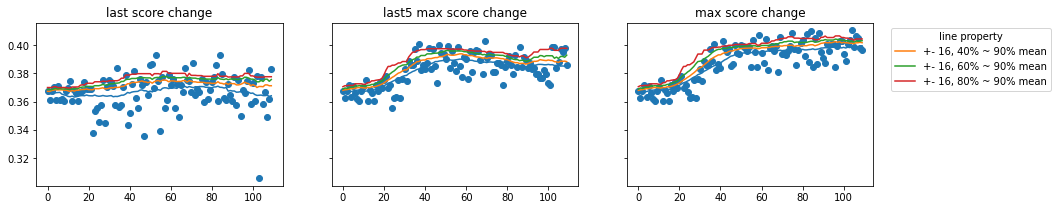

GEN 110
ENV._reset :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] 0 False 0
ENV._step => call set_action [0.46935195 0.46044165 0.49768078 0.40390766 0.56971407 0.54124963]
ENV._step <= return set_action
Epoch 1/20
195/195 [==============================] - 5s 23ms/step - loss: 4.1364 - acc: 0.1101 - sca_2: 0.1709 - sca_3: 0.2170 - sca_4: 0.2544 - scc_0: 4.1382 - scc_1: 4.2599 - scc_2: 4.3815 - scc_3: 4.5032 - scc_4: 4.6249 - scc_5: 4.7466 - scc_6: 4.8683 - scc_7: 4.9900 - scc_8: 5.1117 - scc_9: 5.2333 - val_loss: 4.7103 - val_acc: 0.0258 - val_sca_2: 0.0448 - val_sca_3: 0.0621 - val_sca_4: 0.0777 - val_scc_0: 4.7108 - val_scc_1: 4.7512 - val_scc_2: 4.7915 - val_scc_3: 4.8319 - val_scc_4: 4.8722 - val_scc_5: 4.9125 - val_scc_6: 4.9529 - val_scc_7: 4.9932 - val_scc_8: 5.0336 - val_scc_9: 5.0739
ENV._step => call set_action [0.590657   0.49424392 0.53405416 0.36176586 0.5587412  0.38353205]
ENV._step <= return set_action
Epoch 2/20
195/195 [=======

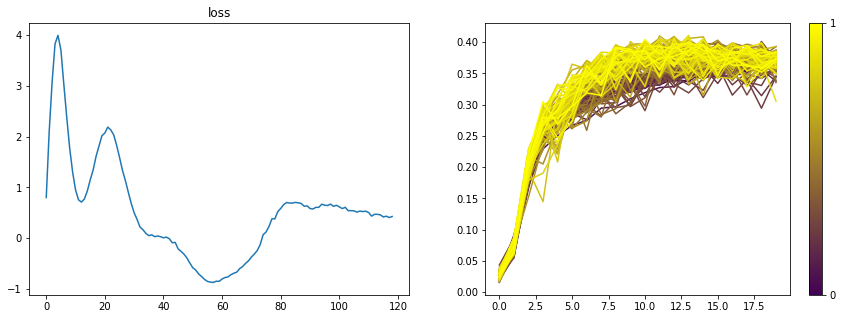

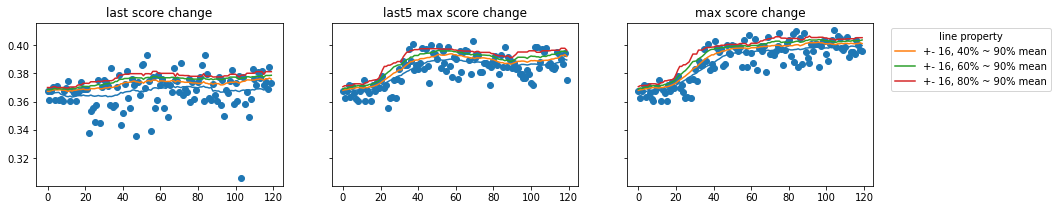

GEN 120
ENV._reset :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] 0 False 0
ENV._step => call set_action [0.47949976 0.48385933 0.44983494 0.45016903 0.576789   0.43114638]
ENV._step <= return set_action
Epoch 1/20
195/195 [==============================] - 5s 24ms/step - loss: 4.1953 - acc: 0.1010 - sca_2: 0.1573 - sca_3: 0.2015 - sca_4: 0.2384 - scc_0: 4.1862 - scc_1: 4.2983 - scc_2: 4.4105 - scc_3: 4.5226 - scc_4: 4.6348 - scc_5: 4.7469 - scc_6: 4.8591 - scc_7: 4.9712 - scc_8: 5.0834 - scc_9: 5.1955 - val_loss: 4.6664 - val_acc: 0.0282 - val_sca_2: 0.0435 - val_sca_3: 0.0609 - val_sca_4: 0.0767 - val_scc_0: 4.6632 - val_scc_1: 4.7021 - val_scc_2: 4.7410 - val_scc_3: 4.7799 - val_scc_4: 4.8188 - val_scc_5: 4.8577 - val_scc_6: 4.8966 - val_scc_7: 4.9355 - val_scc_8: 4.9745 - val_scc_9: 5.0134
ENV._step => call set_action [0.44152546 0.49568933 0.6069167  0.36077857 0.6561291  0.35972893]
ENV._step <= return set_action
Epoch 2/20
195/195 [=======

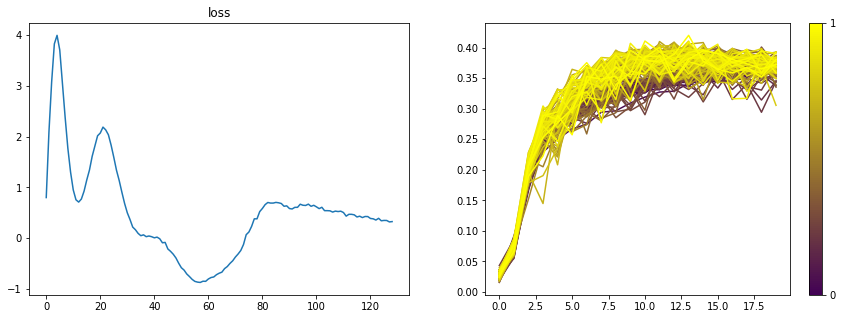

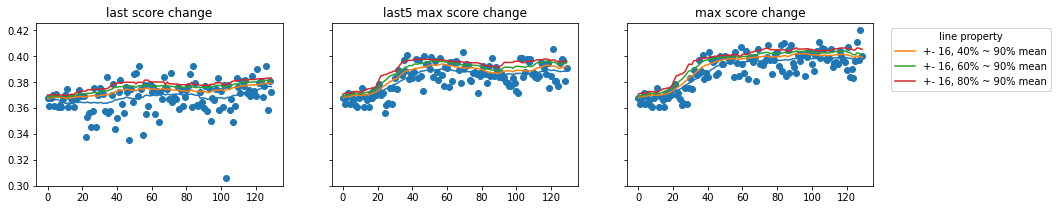

GEN 130
ENV._reset :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] 0 False 0
ENV._step => call set_action [0.5115727  0.50364965 0.5517265  0.4052789  0.50846577 0.40382975]
ENV._step <= return set_action
Epoch 1/20
195/195 [==============================] - 4s 23ms/step - loss: 4.2599 - acc: 0.0893 - sca_2: 0.1418 - sca_3: 0.1822 - sca_4: 0.2171 - scc_0: 4.2611 - scc_1: 4.3627 - scc_2: 4.4642 - scc_3: 4.5658 - scc_4: 4.6673 - scc_5: 4.7689 - scc_6: 4.8705 - scc_7: 4.9720 - scc_8: 5.0736 - scc_9: 5.1751 - val_loss: 4.6418 - val_acc: 0.0245 - val_sca_2: 0.0394 - val_sca_3: 0.0525 - val_sca_4: 0.0680 - val_scc_0: 4.6423 - val_scc_1: 4.6808 - val_scc_2: 4.7193 - val_scc_3: 4.7578 - val_scc_4: 4.7963 - val_scc_5: 4.8348 - val_scc_6: 4.8733 - val_scc_7: 4.9119 - val_scc_8: 4.9504 - val_scc_9: 4.9889
ENV._step => call set_action [0.5216662  0.36310163 0.66500765 0.46985978 0.55145425 0.41163936]
ENV._step <= return set_action
Epoch 2/20
195/195 [=======

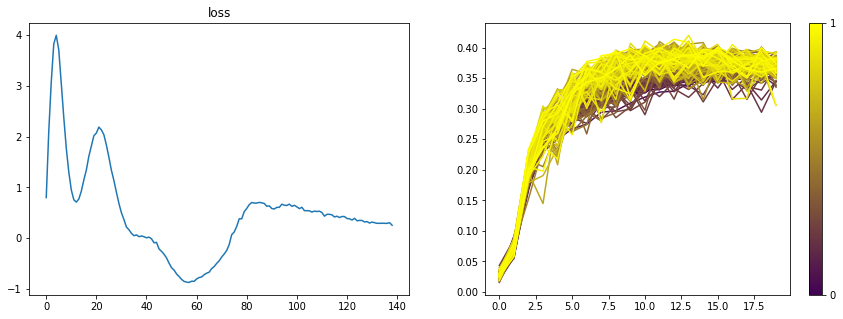

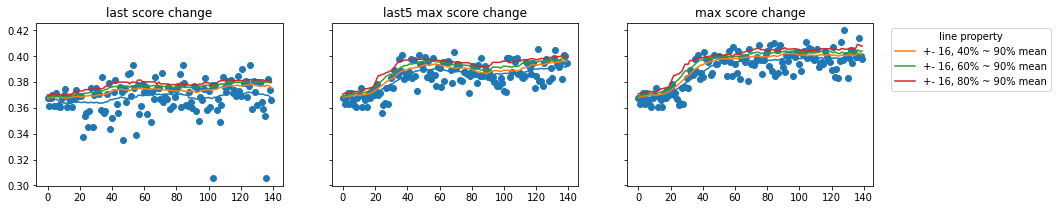

GEN 140
ENV._reset :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] 0 False 0
ENV._step => call set_action [0.4886782  0.52032787 0.4884228  0.45449787 0.5031774  0.5300306 ]
ENV._step <= return set_action
Epoch 1/20
195/195 [==============================] - 5s 23ms/step - loss: 4.2839 - acc: 0.0917 - sca_2: 0.1439 - sca_3: 0.1862 - sca_4: 0.2195 - scc_0: 4.2749 - scc_1: 4.3725 - scc_2: 4.4701 - scc_3: 4.5677 - scc_4: 4.6653 - scc_5: 4.7629 - scc_6: 4.8605 - scc_7: 4.9581 - scc_8: 5.0557 - scc_9: 5.1533 - val_loss: 4.6632 - val_acc: 0.0218 - val_sca_2: 0.0349 - val_sca_3: 0.0528 - val_sca_4: 0.0766 - val_scc_0: 4.6599 - val_scc_1: 4.6962 - val_scc_2: 4.7325 - val_scc_3: 4.7687 - val_scc_4: 4.8050 - val_scc_5: 4.8413 - val_scc_6: 4.8776 - val_scc_7: 4.9139 - val_scc_8: 4.9502 - val_scc_9: 4.9864
ENV._step => call set_action [0.501376   0.44455153 0.5228309  0.4590783  0.64318585 0.3803495 ]
ENV._step <= return set_action
Epoch 2/20
195/195 [=======

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import colors as cmaps
import matplotlib
import numpy as np
def show_enhance(history):
    color_0 = np.asarray([65,0,85, 255])
    color_1 = np.asarray([255, 255,0, 255])
    cmap = []

    fig, axs = plt.subplots(1, 2, figsize = (15, 5))

    for i, hist in enumerate(history):
      progress = (i+0.5) / len(history)
      color = color_1 * progress + color_0 * (1. - progress)
      color = color/255.01
      cmap.append(color)
      axs[1].plot(hist.history['val_acc'], color = color)

    cmap = cmaps.ListedColormap(cmap)
    sm = matplotlib.cm.ScalarMappable(cmap = cmap)
    fig.colorbar(sm, ticks=np.arange(len(history)))

    axs[0].plot(optim.agent.get_history())
    axs[0].set_title('loss')
    plt.show()
    def mean_of_percentile(X, low, upp):return np.mean( sorted(X)[int(len(X) * low):int(len(X) * upp)] )

    fig, axs = plt.subplots(1, 3, sharey = True, figsize = (15, 3))

    finals = [hist.history['val_acc'][-1] for hist in history]
    ax_plt = axs[0]
    ax_plt.scatter(np.arange(len(finals)), finals)
    ax_plt.plot([np.mean(finals[i-len(finals)-16:i + 16]) for i in range(len(finals))], label = "+- 16 mean")
    ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.4, 0.9) for i in range(len(finals))], label = "+- 16, 40% ~ 90% mean")
    ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.6, 0.9) for i in range(len(finals))], label = "+- 16, 60% ~ 90% mean")
    ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.8, 0.9) for i in range(len(finals))], label = "+- 16, 80% ~ 90% mean")
    #ax_plt.legend()
    ax_plt.set_title('last score change')
    #plt.show()

    finals = [max(hist.history['val_acc'][-5:]) for hist in history]
    ax_plt = axs[1]
    ax_plt.scatter(np.arange(len(finals)), finals)
    ax_plt.plot([np.mean(finals[i-len(finals)-16:i + 16]) for i in range(len(finals))], label = "+- 16 mean")
    ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.4, 0.9) for i in range(len(finals))], label = "+- 16, 40% ~ 90% mean")
    ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.6, 0.9) for i in range(len(finals))], label = "+- 16, 60% ~ 90% mean")
    ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.8, 0.9) for i in range(len(finals))], label = "+- 16, 80% ~ 90% mean")
    #ax_plt.legend()
    ax_plt.set_title('last5 max score change')
    #plt.show()

    finals = [max(hist.history['val_acc']) for hist in history]
    ax_plt = axs[2]
    ax_plt.scatter(np.arange(len(finals)), finals)
    ax_plt.plot([np.mean(finals[i-len(finals)-16:i + 16]) for i in range(len(finals))], label = "+- 16 mean")
    p1, = ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.4, 0.9) for i in range(len(finals))], label = "+- 16, 40% ~ 90% mean")
    p2, = ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.6, 0.9) for i in range(len(finals))], label = "+- 16, 60% ~ 90% mean")
    p3, = ax_plt.plot([mean_of_percentile(finals[i-len(finals)-16:i + 16], 0.8, 0.9) for i in range(len(finals))], label = "+- 16, 80% ~ 90% mean")
    ax_plt.legend()
    ax_plt.set_title('max score change')
    ax_plt.legend(handles=[p1, p2, p3], title='line property', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
for gen in range(100, 200):
    if gen and gen % 10 == 0: show_enhance(history)
    print(f"GEN {gen}")
    new_model = build_model()
    model.set_weights(new_model.get_weights())
    model.optimizer.set_weights(opt_W)
    callback = optim.get_callback()
    #asyncio.run(fitting(model, callback))
    history.append(model.fit(TR_DT, validation_data = VL_DT, epochs = max_epochs, callbacks = [callback]))

In [ ]:
opt_parameter

import tf_agents
tf_agents.trajectories.time_step.restart()